In [10]:
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import json
import numpy as np
from zipfile import ZipFile
import glob
import zipfile
from sklearn.neighbors import BallTree
import numpy as np
from shapely.geometry import LineString

In [11]:
def read_gdf_from_zip(zip_fp):
    """
    Reads multiple csv files from ZipFile into a Pandas dataframe.
    """
    for zip_file in glob.glob(zip_fp):
        zf = zipfile.ZipFile(zip_file)
        dfs = [pd.read_csv(zf.open(f),sep=",") for f in zf.namelist()]
        sim_df = pd.concat(dfs,ignore_index=True)
    
    return sim_df

In [12]:
snapshot = read_gdf_from_zip('/Users/vsundar/Documents/personal/smc/data/vehicle_data/Simulation_Snapshot/snapshot.zip')

In [14]:
def start_end(sim_df):
    """
    Reads a spatial dataset from ZipFile into GeoPandas. Assumes that there is only a single file (such as GeoPackage)
    inside the ZipFile.
    """
    sim_snap_df = sim_df.groupby('VEHICLE')   
    sim_start = pd.DataFrame(sim_snap_df.head(1))
    sim_end = pd.DataFrame(sim_snap_df.tail(1))
    sim_end.X_COORD = pd.to_numeric(sim_end.X_COORD)
    sim_end.Y_COORD = pd.to_numeric(sim_end.Y_COORD)
    sim_start.X_COORD = pd.to_numeric(sim_start.X_COORD)
    sim_start.Y_COORD = pd.to_numeric(sim_start.Y_COORD)
    sim_start_gdf = gpd.GeoDataFrame(sim_start, geometry=gpd.points_from_xy(sim_start.X_COORD,sim_start.Y_COORD))
    sim_start_gdf.crs="EPSG:26916"
    sim_start_wgs84 = sim_start_gdf.to_crs(epsg=4326)
    sim_end_gdf = gpd.GeoDataFrame(sim_end, geometry=gpd.points_from_xy(sim_end.X_COORD,sim_end.Y_COORD))
    sim_end_gdf.crs="EPSG:26916"
    sim_end_wgs84 = sim_end_gdf.to_crs(epsg=4326)
    sim_start_wgs84 = sim_start_wgs84.reset_index(drop=True)
    
    return sim_start_wgs84, sim_end_wgs84

In [15]:
sim_start,sim_end = start_end(snapshot)

In [9]:
sim_start

NameError: name 'sim_start' is not defined

In [16]:
def building_prep(building_map:str):
    """ 
    Reads building geojson and prepares data for calculating nearest distance metrics.
    """
    building_map = gpd.read_file(building_map)
    building_map = building_map.assign(centroid=building_map.centroid)
    
    return building_map

In [17]:
##Reads a building mask
building_map = building_prep(building_map= "/Users/vsundar/Documents/personal/smc/smc-cuda-intersect/data/building_data/Building_Footprints/ChicagoLoop_attr.geojson")

In [18]:
## Read a building mask and clip the agents
building_mask = "/Users/vsundar/Documents/personal/smc/smc-cuda-intersect/data/building_data/building_mask/building_mask.shp"
building_mask = gpd.read_file(building_mask)
sim_start_clip = gpd.overlay(sim_start,building_mask)
sim_end_clip = gpd.overlay(sim_end,building_mask)

In [19]:
sim_start_clip

,VEHICLE,TIME,LINK,DIR,LANE,OFFSET,SPEED,ACCEL,VEH_TYPE,DRIVER,PASSENGERS,X_COORD,Y_COORD,id,geometry
0,245126,0:00:30,526,0,1,75.0,15.0,0.0,1,24512601,0,447472.067970,4.637343e+06,1,POINT (-87.63313 41.88627)
1,166155,2:40,57,0,3,112.5,0.0,-30.0,1,16615501,0,447573.359857,4.636864e+06,1,POINT (-87.63187 41.88196)
2,127167,2:47:30,214,1,3,120.0,0.0,0.0,1,12716701,0,446824.617870,4.636856e+06,1,POINT (-87.64089 41.88185)
3,202723,2:47:30,139,1,3,67.5,7.5,-7.5,1,20272301,0,447741.477250,4.635920e+06,1,POINT (-87.62976 41.87347)
4,241483,2:47:30,527,0,1,120.0,7.5,7.5,1,24148301,0,447315.850742,4.637344e+06,1,POINT (-87.63502 41.88627)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96722,176652,1@0:59:30,972,0,1,75.0,0.0,0.0,1,17665201,0,447608.505670,4.634674e+06,1,POINT (-87.63125 41.86224)
96723,174758,1@0:59:30,972,0,1,67.5,0.0,0.0,1,17475801,0,447605.849683,4.634810e+06,1,POINT (-87.63130 41.86347)
96724,93763,1@0:59:30,63,0,2,82.5,0.0,-7.5,1,9376301,0,447600.676242,4.636580e+06,1,POINT (-87.63151 41.87941)
96725,174635,1@0:59:30,972,0,1,60.0,0.0,0.0,1,17463501,0,447603.193859,4.634946e+06,1,POINT (-87.63134 41.86469)


<IPython.core.display.Javascript object>


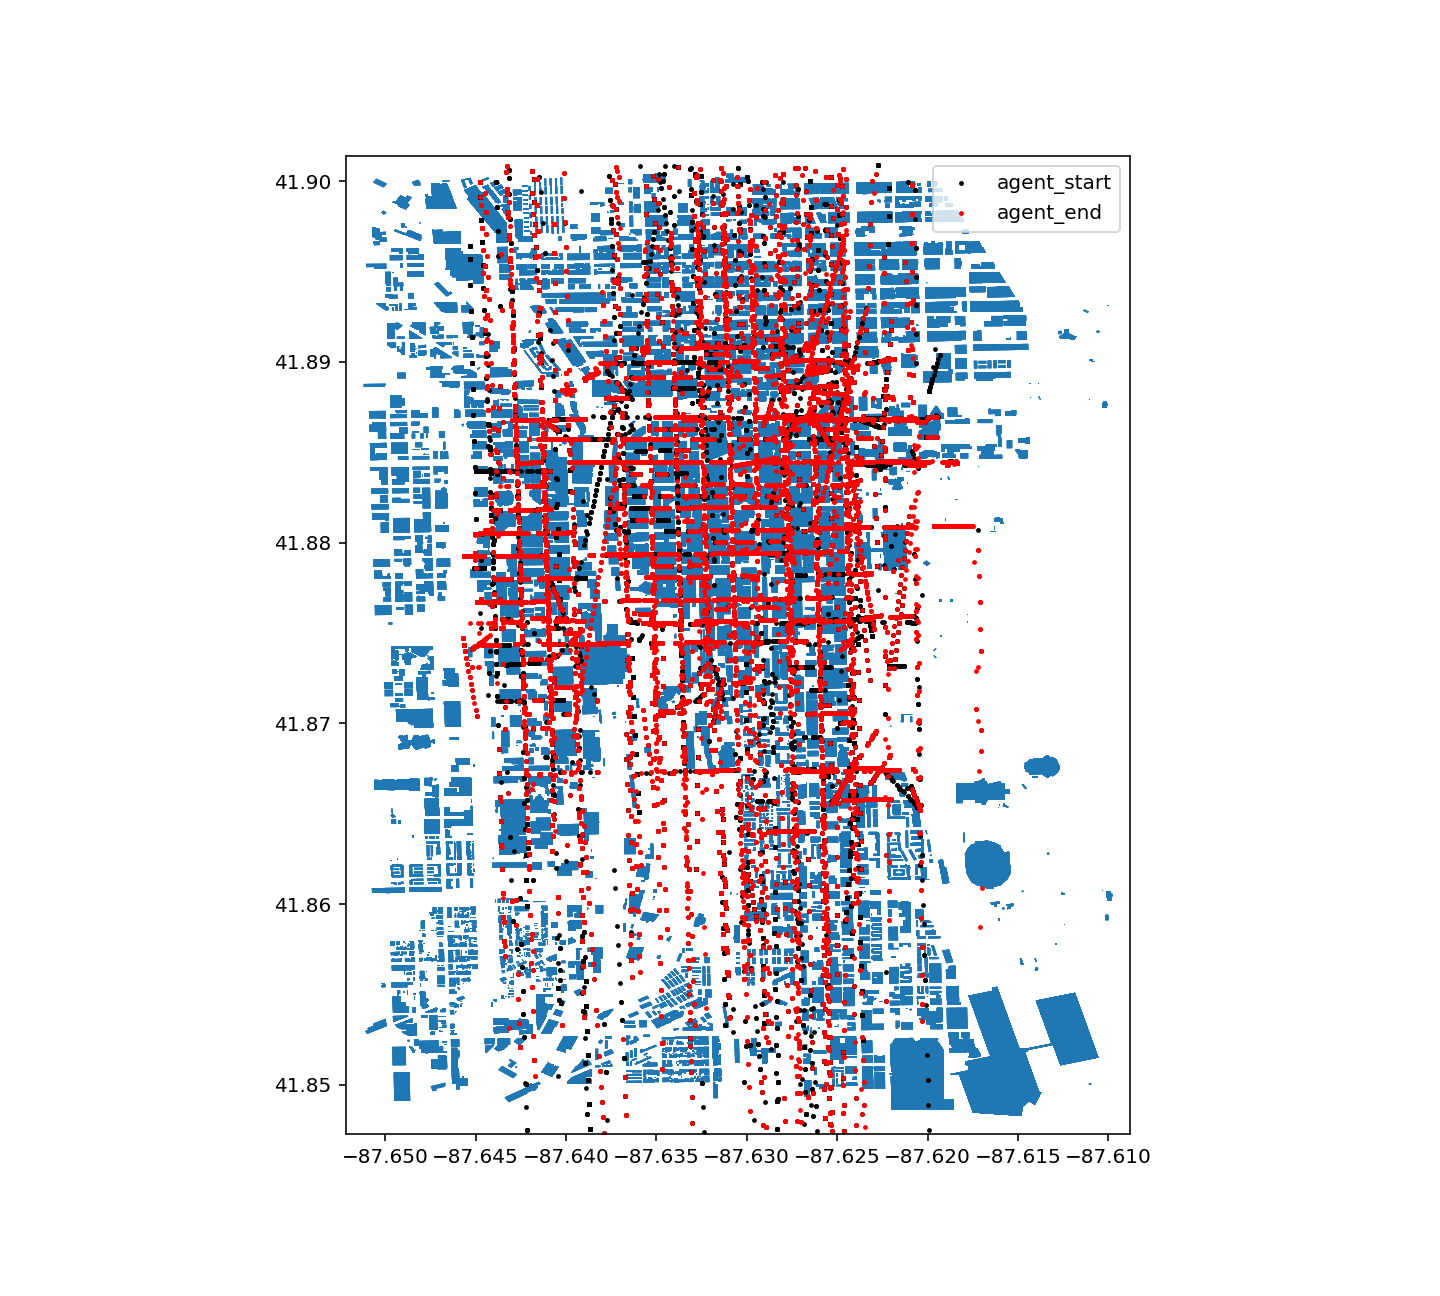

In [30]:
%matplotlib notebook

import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(10,9))
# Plot buildings and start and  
building_map.plot(ax=ax)
sim_start_clip.plot(ax=ax, marker='o', color='black', markersize=2,label='agent_start')
sim_end_clip.plot(ax=ax, marker='o', color='red', markersize=2,label='agent_end')
minx, miny, maxx, maxy = building_map.geometry.total_bounds
# # Margin around total bounds
ax.set_xlim(minx - 0.001, maxx + 0.001)
ax.set_ylim(miny - 0.001, maxy + 0.001)
ax.legend(loc='best')


In [31]:
from sklearn.neighbors import BallTree
import numpy as np

In [33]:
def get_nearest(src_points, candidates, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=15, metric='euclidean')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]

    # Return indices and distances
    return (closest, closest_dist)

In [34]:
def nearest_neighbor(left_gdf, right_gdf, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.
    NOTE: Input points are in wgs84.
    """
    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.centroid

    # Ensure that index in right gdf is formed of sequential numbers
    right = right_gdf.copy().reset_index(drop=True)
#     # Parse coordinates from points and insert them into a numpy array as RADIANS
    left_radians = np.array(left_gdf[left_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    right_radians = np.array(right_geom_col.apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    
    # Find the nearest points
    # -----------------------
    # closest ==> index in right_gdf that corresponds to the closest point
    # dist ==> distance between the nearest neighbors (in meters)
    closest, dist = get_nearest(src_points=left_radians, candidates=right_radians)
    # Return points from right GeoDataFrame that are closest to points in left GeoDataFrame
    closest_points = right.loc[closest]
    print(closest_points)
    # Ensure that the index corresponds the one in left_gdf
    closest_points = closest_points.reset_index(drop=True)

    # Add distance if requested
    if return_dist:
        # Convert to meters from radians
        earth_radius = 6371000  # meters
        closest_points['distance'] = dist * earth_radius
        
    return closest_points

In [35]:
closest_buildings_start = nearest_neighbor(sim_start_clip, building_map, return_dist=True)

               area  perimeter  \
11043  2.395448e-07   0.002148   
1958   3.445150e-07   0.003200   
12445  5.387833e-07   0.003316   
9831   1.016276e-07   0.001286   
3838   3.243570e-07   0.002472   
...             ...        ...   
18052  1.222179e-08   0.000446   
13141  4.890239e-08   0.001000   
17152  3.031794e-07   0.002219   
18940  1.591434e-08   0.000582   
10346  4.538331e-07   0.002736   

                                                geometry  \
11043  POLYGON ((-87.63336 41.88626, -87.63336 41.886...   
1958   POLYGON ((-87.63220 41.88135, -87.63150 41.881...   
12445  POLYGON ((-87.64102 41.88124, -87.63991 41.881...   
9831   POLYGON ((-87.63010 41.87349, -87.63009 41.873...   
3838   POLYGON ((-87.63527 41.88592, -87.63500 41.885...   
...                                                  ...   
18052  POLYGON ((-87.63012 41.86201, -87.63002 41.862...   
13141  POLYGON ((-87.63004 41.86393, -87.63015 41.863...   
17152  POLYGON ((-87.63213 41.87884, -87.63151 41.8

In [36]:
closest_buildings_end = nearest_neighbor(sim_end_clip, building_map, return_dist=True)

               area  perimeter  \
13903  5.133279e-08   0.000978   
5891   1.092253e-06   0.004191   
12445  5.387833e-07   0.003316   
465    2.474583e-07   0.005055   
1748   6.426308e-08   0.001040   
...             ...        ...   
18052  1.222179e-08   0.000446   
13141  4.890239e-08   0.001000   
17152  3.031794e-07   0.002219   
18940  1.591434e-08   0.000582   
10346  4.538331e-07   0.002736   

                                                geometry  \
13903  POLYGON ((-87.63323 41.89603, -87.63291 41.896...   
5891   POLYGON ((-87.63959 41.87217, -87.63962 41.873...   
12445  POLYGON ((-87.64102 41.88124, -87.63991 41.881...   
465    POLYGON ((-87.63228 41.87276, -87.63233 41.875...   
1748   POLYGON ((-87.63319 41.89648, -87.63318 41.896...   
...                                                  ...   
18052  POLYGON ((-87.63012 41.86201, -87.63002 41.862...   
13141  POLYGON ((-87.63004 41.86393, -87.63015 41.863...   
17152  POLYGON ((-87.63213 41.87884, -87.63151 41.8

In [37]:
# Rename the geometry of closest stops gdf so that we can easily identify i
closest_buildings_start = closest_buildings_start.rename(columns={'centroid': 'closest_building_centroid'})
# #remove the 'geometry' polygon column
closest_buildings_st = closest_buildings_start.drop(columns=['geometry']) #polygon
# closest_buildings=closest_buildings.drop(columns=['Unnamed: 0'])
#Merge the datasets by index (for this, it is good to use '.join()' -function)
sim_start_join = sim_start_clip.join(closest_buildings_st)
# Let's see what we have
# closest_buildings_st

<IPython.core.display.Javascript object>


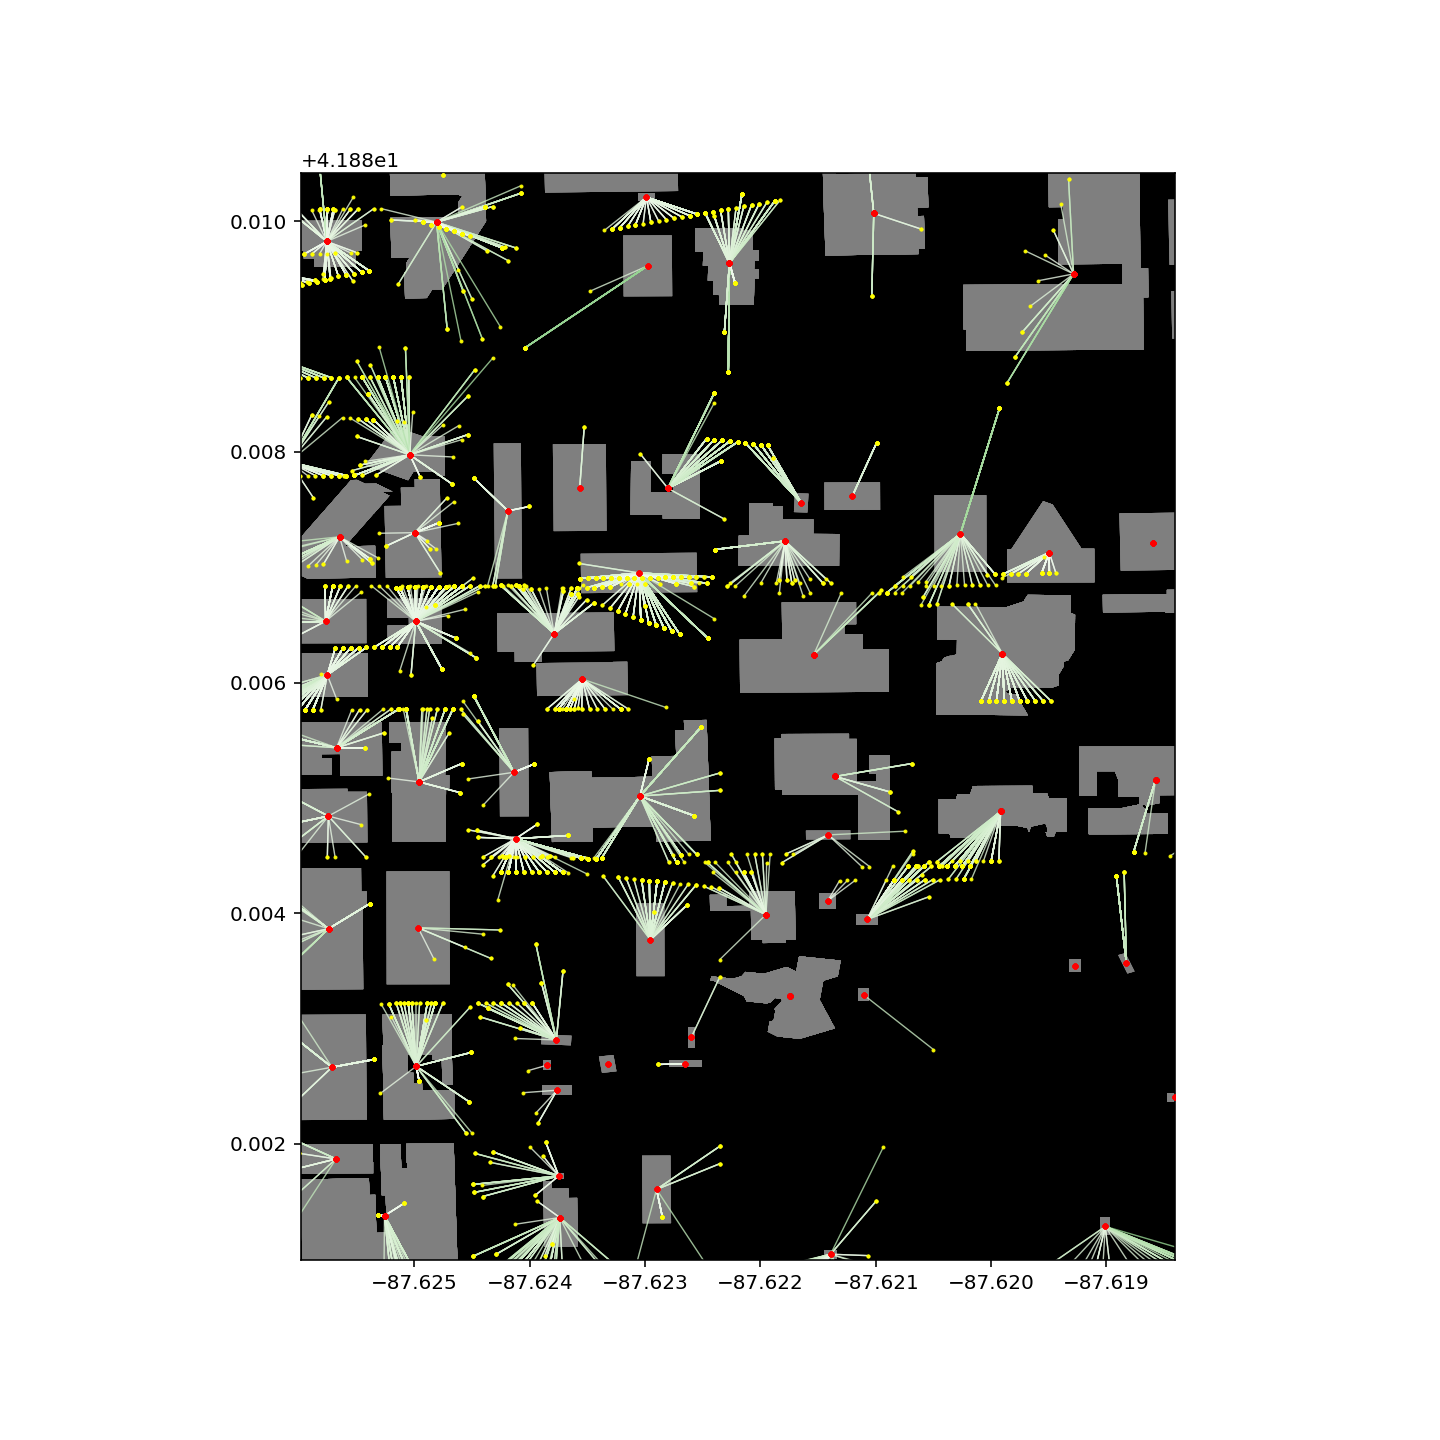

In [38]:

# Create a link (LineString) between building and stop points
sim_start_join['link'] =sim_start_join.apply(lambda row: LineString([row['geometry'], row['closest_building_centroid']]), axis=1)

# Set link as the active geometry
building_links = sim_start_join.copy()
building_links = building_links.set_geometry('link')
%matplotlib notebook
fig, ax= plt.subplots(figsize=(10,10))
ax = building_links.plot(ax=ax,column='distance', cmap='Greens', k=4, alpha=0.8, lw=0.7, figsize=(13, 10))
ax = building_map.plot(ax=ax, color='gray', markersize=1, alpha=0.7)
ax = sim_start_join.plot(ax=ax, markersize=1, marker='o', color='yellow', alpha=0.9, zorder=3)
ax = building_map.centroid.plot(ax=ax, markersize=4, marker='o', color='red', alpha=0.9, zorder=3)

# Zoom closer
#ax.set_xlim([24.99, 25.01])
#ax.set_ylim([])

# Set map background color to black, which helps with contrast
ax.set_facecolor('black')